In [151]:
# Import our dependencies
!pip install psycopg2
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
import plotly.express as px
from matplotlib import pyplot
import hvplot.pandas
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import statistics
from matplotlib.ticker import MultipleLocator
import scipy.stats as sts
import time
import re
from sqlalchemy import create_engine 
import sqlalchemy
import json
import psycopg2
from config import db_password
!pip install ipython-sql
from sklearn.neighbors import KNeighborsClassifier


In [2]:
# Define variable for database connection
protocol = "postgres"
user = "postgres"
location = "localhost"
port = "5432"
db = "Time_Series"

In [4]:
# This is the connection set up for the database

connection = f'{protocol}://{user}:{db_password}@{location}:{port}/{db}'
engine = create_engine(connection)


In [5]:
# Test and verify that Jupyter Notebook is connected and able to read datafrom from PostgresSQL DB
# Display few lines to show proper communication with the database

with engine.connect() as connection:
    result = connection.execute("select * from stocks limit 5")
    for row in result:
       print("Name:", row['name_'])
        

In [6]:
%load_ext sql


In [7]:
# Here we read in the the data from PostgresSQL DB using the Pandas ...pd.read_sql_table.
# Database name is "Time_Series". Table name is "aal_stocks"

# Note: The option is there to read from either the database or the CSV file

aal_stocks_df = pd.read_sql_table('aal_stocks',engine)
aal_stocks_df.head()




In [152]:
# Import our input dataset which is the aal_stocks_5yr.csv. Data file is also available on Github
#aal_stocks_df = pd.read_csv('/users/Test/Resources/aal_stocks_5yr.csv')
#aal_stocks_df.head()

,date_,open_,high_,low_,close_,volume_,name_
0,2/8/2013,15.07,15.12,14.63,14.75,8407500,AAL
1,2/11/2013,14.89,15.01,14.26,14.46,8882000,AAL
2,2/12/2013,14.45,14.51,14.10,14.27,8126000,AAL
3,2/13/2013,14.30,14.94,14.25,14.66,10259500,AAL
4,2/14/2013,14.94,14.96,13.16,13.99,31879900,AAL


In [153]:
aal_stocks_df["date_"] = (pd.to_datetime(aal_stocks_df['date_'].values))
aal_stocks_df.head() 

,date_,open_,high_,low_,close_,volume_,name_
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [162]:
# Check to see if there are null values or missing data. This will show where there is empty
for column in aal_stocks_df2.columns:
    print(f"Column{column} has {aal_stocks_df[column].isnull().sum()} null values" )

Columnopen_ has 0 null values
Columnhigh_ has 0 null values
Columnlow_ has 0 null values


In [164]:
# Generate our categorical variable list
aal_stocks_cat =  aal_stocks_df2.dtypes[ aal_stocks_df2.dtypes == "object"].index.tolist()

display(aal_stocks_cat)

[]

In [165]:
# Check the number of unique values in each column
aal_stocks_df2[aal_stocks_cat].nunique()

Series([], dtype: float64)

In [187]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
aal_stocks_encode_df = pd.DataFrame(enc.fit_transform(aal_stocks_df2[aal_stocks_cat]))

# Add the encoded variable names to the DataFrame
aal_stocks_encode_df.columns = enc.get_feature_names(aal_stocks_cat)


In [167]:
# Merge one-hot encoded features and drop the originals
aal_stocks_df2 =  aal_stocks_df2.merge(aal_stocks_encode_df,left_index=True, right_index=True)

aal_stocks_df2 = aal_stocks_df2.drop(aal_stocks_cat,1)

aal_stocks_df2.head()

,open_,high_,low_
0,15.07,15.12,14.63
1,14.89,15.01,14.26
2,14.45,14.51,14.10
3,14.30,14.94,14.25
4,14.94,14.96,13.16


In [168]:
# Drop Nas and nulls
aal_stocks_df2 = aal_stocks_df2.dropna(how="all")

for column in aal_stocks_df2.columns:
    print(f"Column{column} has {aal_stocks_df2[column].isnull().sum()} null values" )

aal_stocks_df2.head()

Columnopen_ has 0 null values
Columnhigh_ has 0 null values
Columnlow_ has 0 null values


,open_,high_,low_
0,15.07,15.12,14.63
1,14.89,15.01,14.26
2,14.45,14.51,14.10
3,14.30,14.94,14.25
4,14.94,14.96,13.16


In [169]:
# Standardize data with StandardScaler. This will standardize all the data stored in X_df dataframe.
aal_stocks_scaled = StandardScaler().fit_transform(aal_stocks_df2)
print(aal_stocks_scaled)

[[-2.12725269 -2.15331212 -2.13994527]
 [-2.14367196 -2.16324955 -2.17408017]
 [-2.18380795 -2.20841973 -2.18884121]
 ...
 [ 1.24052178  1.21367248  1.10010291]
 [ 0.99696929  1.13326957  1.01153668]
 [ 1.14200617  1.17663294  1.20527532]]


In [170]:
# Normalise the data to be processed
from sklearn import preprocessing
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(aal_stocks_df2.values.reshape(-1, 1))


In [188]:
# In this case I chose to predict the closing value "close", which will be the 'y' or "aal_stocks_df["close_"]
# Imputs are everything else without the closing value, which are in the DataFrame "aal_stocks_df2"
# Split into features and target arrays. 
y = aal_stocks_df["close_"].values
X = aal_stocks_df2.values      # This line could also be replaced by aal_stocks_df.drop["date_", "close_", "volume_"]


# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78) 

In [189]:
# Create a StandardScaler instance
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X_train)

# Scale the data

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [193]:
# Create a Linear Regression model. This is the actual statistical model for this experiment.
model = LinearRegression()


# Fitting the model, we use model.fit(). The above code line could also be combined with fit()
model.fit(X, y)

# Get the coefficient of determination
r_sq = model.score(X, y)
print('Coefficient of determination:', r_sq)
print('Intercept:', model.intercept_)
print('Slope:', model.coef_)


# Predict "y"
y_pred = model.predict(X)
print('Predicted Response:', y_pred, sep='\n')



Coefficient of determination: 0.9990356371118271
Intercept: -0.0027011866939048446
Slope: [-0.56716585  0.83525458  0.73050852]
Predicted Response:
[14.76649833 14.50642203 14.22146635 ... 50.61213251 50.68180058
 51.71499697]


In [185]:
# This part of the code is purpose to set up the environment for alternate model using deep neural network
# Define the model - deep neural network
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  4
hidden_nodes_layer2 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

#  Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

#  Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [186]:
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/100
944/944 [==============================] - 1s 1ms/sample - loss: 8.0909 - acc: 0.0000e+00
Epoch 2/100
944/944 [==============================] - 0s 41us/sample - loss: 2.9755 - acc: 0.0000e+00
Epoch 3/100
944/944 [==============================] - 0s 44us/sample - loss: -1.5985 - acc: 0.0000e+00
Epoch 4/100
944/944 [==============================] - 0s 41us/sample - loss: -6.4454 - acc: 0.0000e+00
Epoch 5/100
944/944 [==============================] - 0s 81us/sample - loss: -12.3256 - acc: 0.0000e+00
Epoch 6/100
944/944 [==============================] - 0s 66us/sample - loss: -19.0697 - acc: 0.0000e+00
Epoch 7/100
944/944 [==============================] - 0s 45us/sample - loss: -26.7359 - acc: 0.0000e+00
Epoch 8/100
944/944 [==============================] - 0s 37us/sample - loss: -35.4834 - acc: 0.0000e+00
Epoch 9/100
944/944 [==============================] - 0s 35us/sample - loss: -45.4843 - acc: 0.0000e+00
Epoch 10/100
944/944 [==============================] - 0s 53u

VISUALIZATION

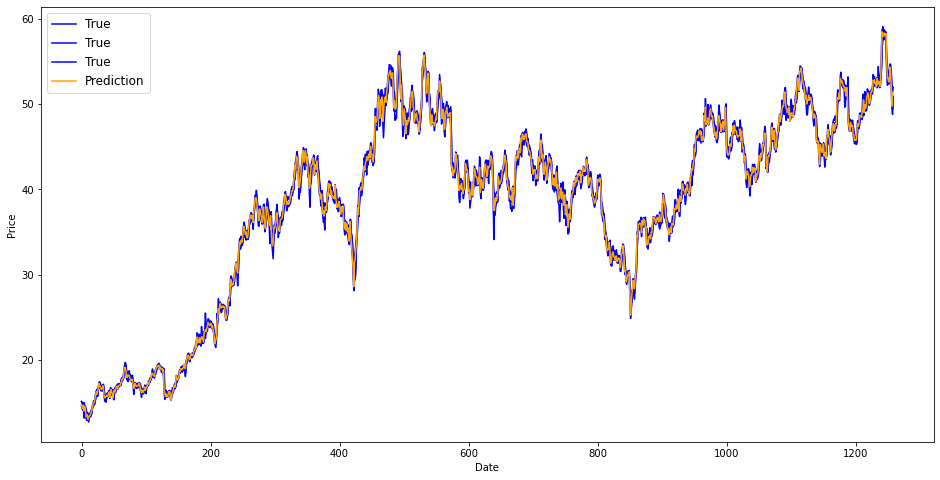

In [205]:
# Plot the input and the True and Prediction
plt.figure(figsize = (16,8))
plt.plot(range(1259),aal_stocks_df2.values,color='b',label='True')
plt.plot(range(1259), aal_stocks_df.close_,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(fontsize=12)
plt.show()